In [1]:
from optparse import OptionParser
import json
import os
import pickle
import random
import re
import pandas as pd
import pysam
# import h5py
import numpy as np

import tensorflow as tf
from basenji import seqnn, stream

from akita_utils.seq_gens import central_permutation_seqs_gen
from akita_utils.h5_utils import (initialize_stat_output_h5, write_stat_metrics_to_h5)
from akita_utils.df_utils import split_df_equally

2024-11-05 11:19:23.245918: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-05 11:19:23.272239: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-05 11:19:23.272266: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-05 11:19:23.273022: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-05 11:19:23.278547: I tensorflow/core/platform/cpu_feature_guar

In [2]:
from akita_utils.dna_utils import hot1_rc, dna_1hot
from akita_utils.dna_utils import permute_seq_k

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
Bonev2017_mESC_path = "/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/HiC_ES_all.mm10.mapq_30.2048.cool"

In [5]:
import warnings
warnings.filterwarnings("ignore") 

import numpy as np
import pandas as pd
import cooler
from cooltools.lib.numutils import observed_over_expected, adaptive_coarsegrain
from cooltools.lib.numutils import interpolate_bad_singletons, set_diag, interp_nan
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from bioframe.io.fileops import read_bigwig

In [7]:
def get_target(cooler_path, padding, mseq_str, diagonal_offset=2):
    
    genome_hic_cool = cooler.Cooler(cooler_path)
    
    seq_hic_raw = genome_hic_cool.matrix(balance=True).fetch(mseq_str)

    seq_hic_nan = np.isnan(seq_hic_raw)
    # num_filtered_bins = np.sum(np.sum(seq_hic_nan,axis=0) == len(seq_hic_nan))

    # clip first diagonals and high values
    clipval = np.nanmedian(np.diag(seq_hic_raw, diagonal_offset))
    for i in range(-diagonal_offset+1, diagonal_offset):
        set_diag(seq_hic_raw, clipval, i)
    seq_hic_raw = np.clip(seq_hic_raw, 0, clipval)
    seq_hic_raw[seq_hic_nan] = np.nan
    
    # adaptively coarsegrain based on raw counts
    seq_hic_smoothed = adaptive_coarsegrain(
                        seq_hic_raw,
                        genome_hic_cool.matrix(balance=False).fetch(mseq_str),
                        cutoff=2, max_levels=8)
    seq_hic_nan = np.isnan(seq_hic_smoothed)
    
    # local obs/exp
    seq_hic_obsexp = observed_over_expected(seq_hic_smoothed, ~seq_hic_nan)[0]
    log_hic_obsexp = np.log(seq_hic_obsexp)

    # crop
    if padding > 0:
        log_hic_obsexp = log_hic_obsexp[padding:-padding,:]
        log_hic_obsexp = log_hic_obsexp[:,padding:-padding]

    # aplying Gaussian Kernel
    # kernel = Gaussian2DKernel(x_stddev=1)
    # kernel_log_hic_obsexp = convolve(log_hic_obsexp, kernel)
    
    # return kernel_log_hic_obsexp
    return log_hic_obsexp

In [8]:
seq_len_nt = 1310720
padding = (640-512) // 2

In [9]:
# parameters
genome_fasta = "/project/fudenber_735/genomes/mm10/mm10.fa"
out_dir = "./"
rc = False
stats = "SCD"
shifts = "0"

In [10]:
targets_file = None

In [11]:
batch_size = 4

In [12]:
models_dir = "/project/fudenber_735/tensorflow_models/akita/v2/models"

In [13]:
model_index = 0
head_index = 1 #mouse
# head_index = 0 #human

In [14]:
params_file = models_dir + f"/f{model_index}c0/train/params.json"

In [15]:
params_file

'/project/fudenber_735/tensorflow_models/akita/v2/models/f0c0/train/params.json'

In [16]:
model_file = models_dir + f"/f{model_index}c0/train/" + f"model{head_index}_best.h5"

In [17]:
model_file

'/project/fudenber_735/tensorflow_models/akita/v2/models/f0c0/train/model1_best.h5'

In [18]:
# tsv_file = "./all_explained_boundaries.tsv"
tsv_file = "./all_unexplained_boundaries.tsv"

In [19]:
shifts = [int(shift) for shift in shifts.split(",")]
stats = stats.split(",")

random.seed(44)

In [20]:
# read model parameters
with open(params_file) as params_open:
    params = json.load(params_open)
params_train = params["train"]
params_model = params["model"]

if batch_size is None:
    batch_size = params_train["batch_size"]
else:
    batch_size = batch_size

In [21]:
# load model
seqnn_model = seqnn.SeqNN(params_model)
seqnn_model.restore(model_file, head_i=head_index)
seqnn_model.build_ensemble(rc, shifts)
seq_length = int(params_model["seq_length"])

# dummy target info
if targets_file is None:
    num_targets = seqnn_model.num_targets()
    target_ids = [ti for ti in range(num_targets)]
    target_labels = [""] * len(target_ids)

2024-11-05 11:21:01.410900: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43626 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequence (InputLayer)       [(None, 1310720, 4)]         0         []                            
                                                                                                  
 stochastic_reverse_complem  ((None, 1310720, 4),         0         ['sequence[0][0]']            
 ent (StochasticReverseComp   ())                                                                 
 lement)                                                                                          
                                                                                                  
 stochastic_shift (Stochast  (None, 1310720, 4)           0         ['stochastic_reverse_complemen
 icShift)                                                           t[0][0]']               

In [22]:
seq_coords_df = pd.read_csv(tsv_file, sep="\t", index_col=None)

In [ ]:
# df1 = seq_coords_df[(seq_coords_df['SCD_h1_m0_t1'] > 20) & (seq_coords_df['SCD_h1_m0_t1'] < 30)].sample(n=5, random_state=1)
# df2 = seq_coords_df[(seq_coords_df['SCD_h1_m0_t1'] > 40) & (seq_coords_df['SCD_h1_m0_t1'] < 50)].sample(n=5, random_state=1)
# df3 = seq_coords_df[(seq_coords_df['SCD_h1_m0_t1'] > 60) & (seq_coords_df['SCD_h1_m0_t1'] < 70)].sample(n=5, random_state=1)
# df4 = seq_coords_df.nlargest(5, 'SCD_h1_m0_t1')

In [25]:
df1 = seq_coords_df[seq_coords_df["miss_per"] > 15].sample(n=10, random_state=1)

In [30]:
df2 = seq_coords_df[seq_coords_df["ins16_min"] > -0.3].sample(n=10, random_state=1)

In [31]:
# sampled_seq_coords_df = pd.concat([df1, df2, df3, df4]).reset_index(drop=True)
sampled_seq_coords_df = pd.concat([df1, df2]).reset_index(drop=True)

In [ ]:
# sampled_seq_coords_df = seq_coords_df.sample(n=50, random_state=1).reset_index(drop=True)

In [32]:
SCD_tg1 = sampled_seq_coords_df["SCD_h1_m0_t1"]

In [33]:
bin_size = 2048

In [34]:
# open genome FASTA
genome_open = pysam.Fastafile(genome_fasta)

In [35]:
hic_matrices = []

for index, row in sampled_seq_coords_df.iterrows():
    mseq_str = '%s:%d-%d' % (row.chrom, row.window_start, row.window_end)
    hic_matrices.append(get_target(Bonev2017_mESC_path, padding, mseq_str))

In [36]:
def tad_disruption_seq_gen(seq_coords_df, genome_open):
    
    for s in seq_coords_df.itertuples():
        list_1hot = []
        window_start = s.window_start
        window_end = s.window_end
        chrom = s.chrom
        rel_disruption_start = s.rel_disruption_start
        rel_disruption_end =s.rel_disruption_end
        
        # wild type
        wt_seq_1hot = dna_1hot(
                    genome_open.fetch(chrom, window_start, window_end).upper()
                )
        list_1hot.append(wt_seq_1hot)
    
        alt_seq_1hot = wt_seq_1hot.copy()
        permuted_span = permute_seq_k(
                alt_seq_1hot[rel_disruption_start:rel_disruption_end], k=8
            )
        alt_seq_1hot[rel_disruption_start:rel_disruption_end] = permuted_span
        list_1hot.append(alt_seq_1hot)
            
        # yielding first the reference, then the permuted sequence
        for sequence in list_1hot:
            yield sequence

In [ ]:
# initialize output
# stats_out = initialize_stat_output_h5(out_dir, model_file, stats, seq_coords_df)

# print("stat_h5_outfile initialized")

In [37]:
preds_stream = stream.PredStreamGen(
        seqnn_model,
        tad_disruption_seq_gen(sampled_seq_coords_df, genome_open),
        batch_size,
    )

In [38]:
from akita_utils.stats_utils import calculate_SCD #, plot_map

In [39]:
from akita_utils.numpy_utils import ut_dense

In [ ]:
# 0	Hsieh2019_mESC_uC	/home/drk/hic/data/data/coolers/mm10/Hsieh2019/mESC_mm10_4DNFILZ1CPT8.mapq_30.2048.cool	HIC:mESC
# 1	Bonev2017_mESC	/home/drk/hic/data/data/coolers/mm10/Bonev2017/HiC_ES_all.mm10.mapq_30.2048.cool	HIC:mESC
# 2	Bonev2017_CN	/home/drk/hic/data/data/coolers/mm10/Bonev2017/HiC_CN_all.mm10.mapq_30.2048.cool	HIC:cortical neuron
# 3	Bonev2017_ncx_CN	/home/drk/hic/data/data/coolers/mm10/Bonev2017/HiC_ncx_CN_all.mm10.mapq_30.2048.cool	HIC:neocortex cortical neuron
# 4	Bonev2017_NPC	/home/drk/hic/data/data/coolers/mm10/Bonev2017/HiC_NPC_all.mm10.mapq_30.2048.cool	HIC:neural progenitor cell
# 5	Bonev2017_ncx_NPC	/home/drk/hic/data/data/coolers/mm10/Bonev2017/HiC_ncx_NPC_all.mm10.mapq_30.2048.cool	HIC:neocortex neural progenitor cell

In [ ]:
# human
# 0	HFF	../../data/data/coolers/Krietenstein2019/HFF_hg38_4DNFIP5EUOFX.mapq_30.2048.cool	384	sum	HIC:HFF
# 1	H1hESC	../../data/data/coolers/Krietenstein2019/H1hESC_hg38_4DNFI1O6IL1Q.mapq_30.2048.cool	384	sum	HIC:H1hESC
# 2	GM12878	../../data/data/coolers/Rao2014/GM12878_inSitu_MboI_all.hg38.2048.cool	384	sum	HIC:GM12878
# 3	IMR90	../../data/data/coolers/Rao2014/IMR90_inSitu_MboI_all.hg38.2048.cool	384	sum	HIC:IMR90
# 4	HCT116	../../data/data/coolers/Rao2017/Unsynchronized_all.hg38.2048.cool	384	sum	HIC:HCT116

In [40]:
num_preds = len(sampled_seq_coords_df) * 2

In [43]:
def plot_maps_with_labels(maps, labels, name="plot.pdf", vmin=-0.6, vmax=0.6, palette="RdBu_r", width=20, height=5.5):
    fig, axes = plt.subplots(1, len(maps), figsize=(width, height))

    for i, (matrix, label) in enumerate(zip(maps, labels)):
        sns.heatmap(
            matrix,
            vmin=vmin,
            vmax=vmax,
            cbar=False,
            cmap=palette,
            square=True,
            xticklabels=False,
            yticklabels=False,
            ax=axes[i]
        )
        # axes[i].set_title(label, fontsize=20)  # Set the label above the heatmap

    plt.tight_layout()
    plt.savefig(name, format="pdf")
    plt.show()

In [ ]:
# for i in range(20):

#     matrix = hic_matrices[i]
#     total_elements = matrix.size
#     nan_count = np.isnan(matrix).sum()
#     nan_percentage = (nan_count / total_elements) * 100
    
#     print("matrix", i)
#     print(nan_percentage)
    
#     sns.heatmap(
#         hic_matrices[i],
#         vmin=-0.6,
#         vmax=0.6,
#         cbar=False,
#         cmap="RdBu_r",
#         square=True,
#         xticklabels=False,
#         yticklabels=False,
#             )
    
#     plt.show()

2024-11-05 11:26:02.547988: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


8/8 [==============================] - 9s 247ms/step
PERMUATION 1
pred_index=  1


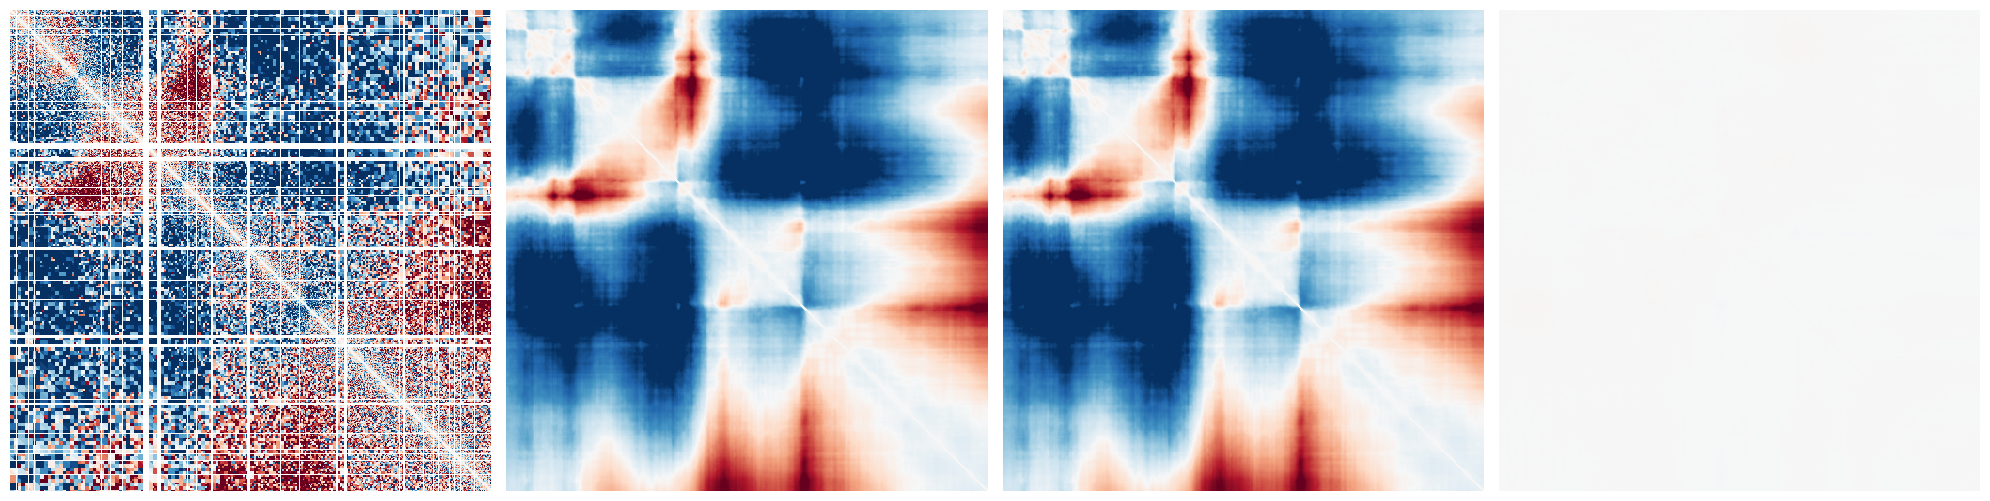

PERMUATION 3
pred_index=  3


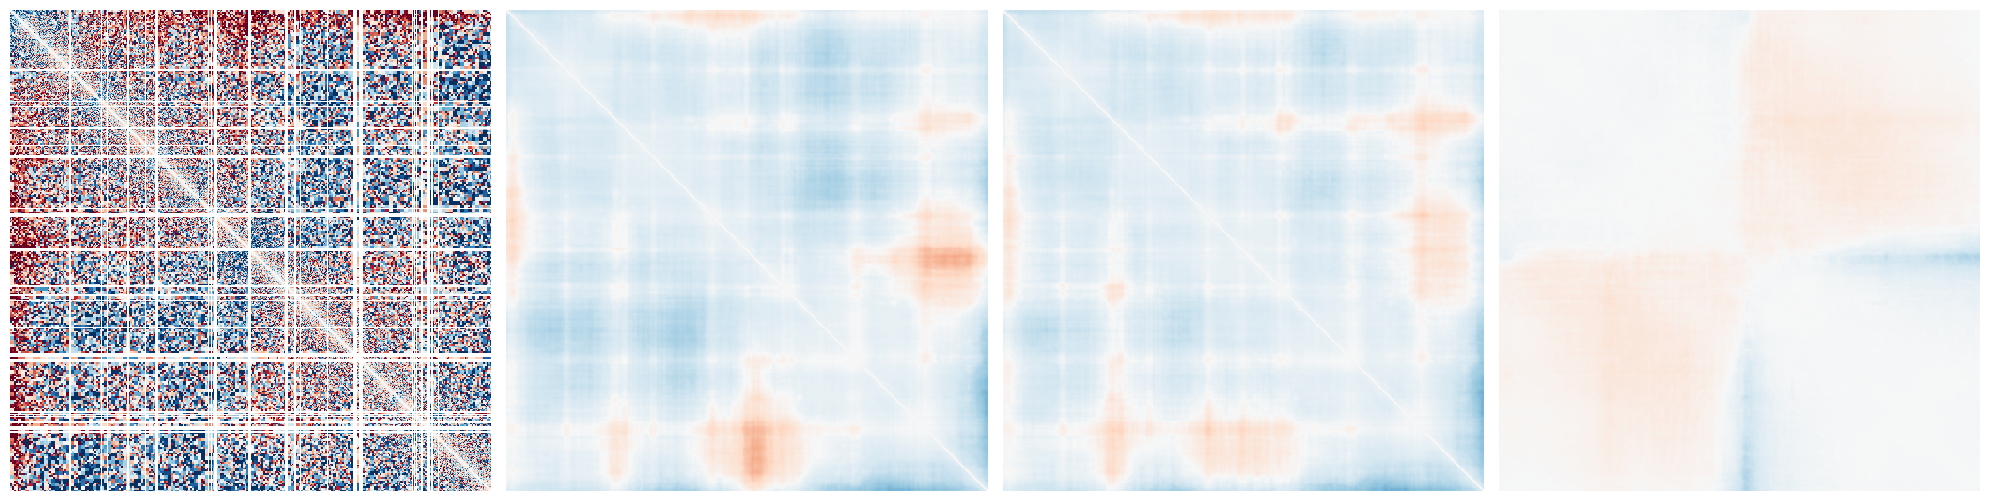

PERMUATION 5
pred_index=  5


KeyboardInterrupt: 

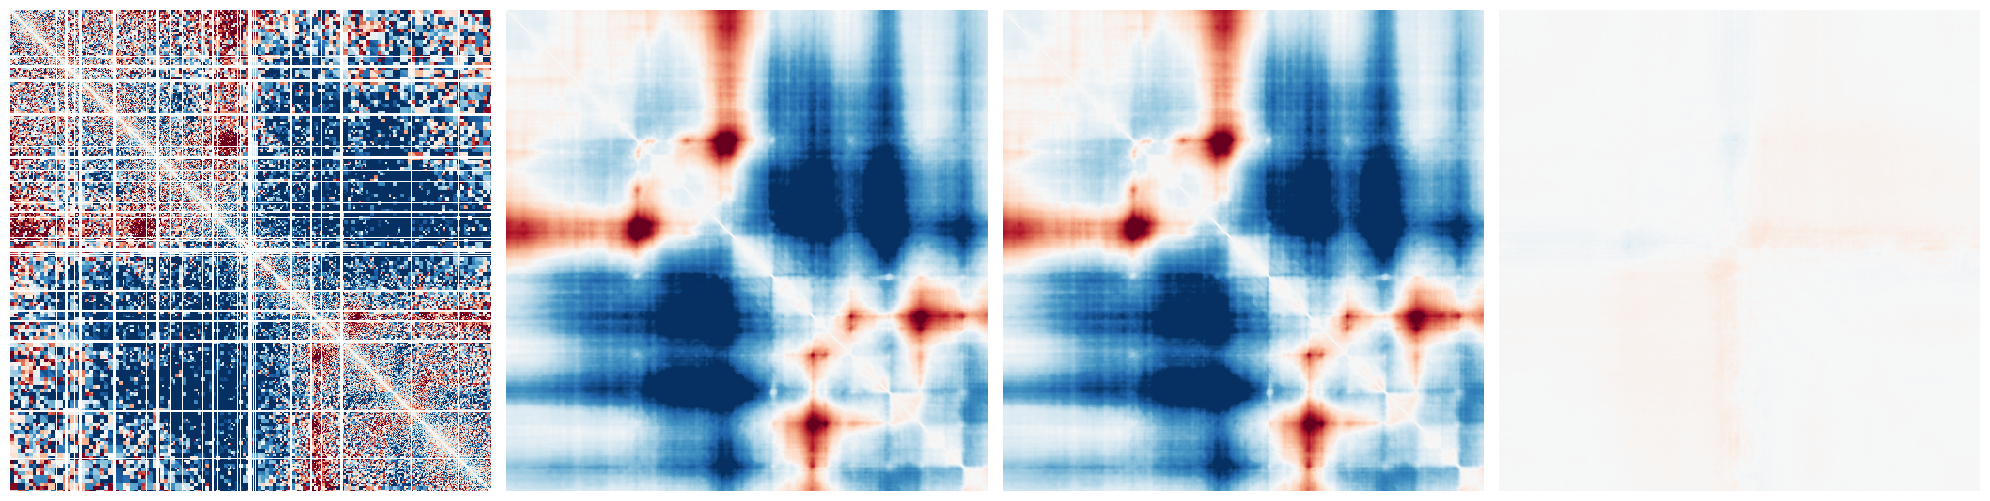

In [42]:
exp_index = 0

matrices = []

for pred_index in range(num_preds):
    
    if pred_index % 2 == 0:
        # only wild types
        # print("REFERENCE")
        # print("pred_index= ", pred_index)
        ref_preds_matrix = preds_stream[pred_index]
        ref_map = ut_dense(ref_preds_matrix, diagonal_offset=2)
        matrices.append(hic_matrices[exp_index])
        matrices.append(ref_map[:,:,1])
        
        file_name = f"/scratch1/smaruj/disruption_plots/unexplained_tads/{SCD_tg1[exp_index]}" + "_target_pred_comp.pdf"
        # file_name = "./plots/" + "{:.2f}".format(scd[1]) + "_target_pred_comp.png"
        plot_maps_with_labels(matrices, labels=["target", "reference"], name=file_name)
        
    else:
        print("PERMUATION", pred_index)
        print("pred_index= ", pred_index)
        permuted_preds_matrix = preds_stream[pred_index]
        permuted_map = ut_dense(permuted_preds_matrix, diagonal_offset=2)
        label = f"difference, DS = {SCD_tg1[exp_index]}"
        # scd_mean = np.mean(scd)
        # label = f"difference, DS = {scd_mean[1]}"
        # matrices.append(permuted_map[:,:,1])
        # matrices.append(permuted_map[:,:,1]-ref_map[:,:,1])
        
        # SCD_list.append(scd_mean)
        # print(scd)
        # print("mean: ", scd_mean)
        # print(scd)
        # plot_map(permuted_map[:,:,1])
        # print("difference map")
        # plot_map(permuted_map[:,:,1]-ref_map[:,:,1])
        
        # file_name = f"/scratch1/smaruj/disruption_plots/unexplained_tads/{SCD_tg1[exp_index]}" + "_target_pred_comp.pdf"
        # # file_name = "./plots/" + "{:.2f}".format(scd[1]) + "_target_pred_comp.png"
        # plot_maps_with_labels(matrices, labels=["target", "reference", "disruption", label], name=file_name)
        
        matrices = []
        
        # write_stat_metrics_to_h5(
        #         permuted_preds_matrix,
        #         ref_preds_matrix,
        #         stats_out,
        #         exp_index,
        #         head_index,
        #         model_index,
        #         diagonal_offset=2,
        #         stat_metrics=stats,
        #     )
        exp_index += 1

In [ ]:
genome_open.close()